In [1]:
%matplotlib inline
import os
from pathlib import Path
from torch.utils.data import DataLoader
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # avoid conflict with conda packages and pip packages

In [2]:
script_dir = Path(os.getcwd()).resolve()
project_dir = script_dir.parent
root_dir = project_dir / "data"
miniCOCO_ROOT = root_dir / "mini_coco_det"

因為COCO dataset的建構過程，會將(img, anns: List)傳給transform函數，

但是transform只收一個變數，吃到兩個會有錯誤。

所以要transform的話就要利用wrapper，傳入兩個變數，但是只將img的部分transform。

In [ ]:
import pathlib
import torch
from utils import MiniVOCSegDataset
from torchvision.datasets import CocoDetection, ImageFolder
def get_loaders(task, batch_size, num_workers, data_root, device: torch.device):
    pin = (device.type == "cuda")
    root = pathlib.Path(data_root)
    if task=='seg':
        ds1 = MiniVOCSegDataset(root/'mini_voc_seg','train')
        ds2 = MiniVOCSegDataset(root/'mini_voc_seg','val')
        return {"train":DataLoader(dataset=ds1,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=pin),
                "val": DataLoader(dataset=ds2,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=pin)}
    if task=='det':
        ds1 = CocoDetection(root/'mini_coco_det'/'train', root/'mini_coco_det'/'annotations'/'instances_train.json')
        ds2 = CocoDetection(root/'mini_coco_det'/'val', root/'mini_coco_det'/'annotations'/'instances_val.json')
        return {"train":DataLoader(dataset=ds1,batch_size=batch_size,shuffle=True,num_workers=num_workers, pin_memory=pin),
                "val": DataLoader(dataset=ds2,batch_size=batch_size,shuffle=False,num_workers=num_workers, pin_memory=pin)}
    if task=='cls':
        ds1 = ImageFolder(root/'imagenette160'/'train')
        ds2 = ImageFolder(root/'imagenette160'/'val')
        return {"train":DataLoader(dataset=ds1,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=pin),
                "val": DataLoader(dataset=ds2,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=pin)}
    raise ValueError(f"Unknown task {task}")

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

tasks      = ['seg', 'det', 'cls']
splits     = ['train', 'val']
batch_size = 16
num_workers= 0
max_samples= 1000   # 每個 split 最多取 1000 張來估分布

fig, axs = plt.subplots(len(tasks), len(splits), figsize=(10, 8), sharex='col', sharey='row')

for i, task in enumerate(tasks):
    loaders = get_loaders(task, batch_size, num_workers, root_dir, torch.device("cuda"))
    for j, split in enumerate(splits):
        dataset = loaders[split].dataset
        widths, heights = [], []

        for idx in range(len(dataset)):
            if idx >= max_samples:
                break
            img, mask = dataset.__getitem__(idx)
            if isinstance(img, Image.Image):
                w, h = img.size
            elif isinstance(img, torch.Tensor):
                # Tensor shape = (C, H, W)
                _, h, w = img.shape
            else:  # np.ndarray
                h, w = img.shape[:2]

            widths.append(w)
            heights.append(h)

        ratios = np.array(widths) / np.array(heights)
        ax = axs[i, j]

        # 畫直方圖
        ax.hist(ratios, bins=30, density=True, alpha=0.6, edgecolor='black')
        # 如果想再加 KDE：
        # from scipy.stats import gaussian_kde
        # kde = gaussian_kde(ratios)
        # xi  = np.linspace(ratios.min(), ratios.max(), 200)
        # ax.plot(xi, kde(xi), linewidth=2)

        ax.set_title(f"{task} — {split}")
        if i == len(tasks)-1:
            ax.set_xlabel("w/h")
        if j == 0:
            ax.set_ylabel("Density")

plt.tight_layout()
plt.show()


TypeError: as_tensor() takes 1 positional argument but 2 were given

這裡設置一個img資料型態的檢查站，如果有啟用transform的toTensor可以不用再做修改。

det_transform:

1. transforms.ToTensor(): 把圖片的像素值(0~255) scale 到 0~1，也就是除以255

2. transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]): 依據ImageNet的資料做normalize

In [147]:
if isinstance(img, torch.Tensor):
    # Tensor: [C, H, W] ➜ [H, W, C] 再轉 numpy
    img = img.permute(1, 2, 0).numpy()

    # 恢復到 [0, 1] 範圍
    img = img*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  
    img = np.clip(img, 0, 1)

    # 恢復到 [0, 255] 範圍並轉成 uint8
    img = (img * 255).astype(np.uint8)
elif isinstance(img, np.ndarray):
    # NumPy: 已是 [H, W, C] 或 [H, W]，不用動
    pass

else:
    # PIL.Image ➜ 轉成 numpy
    img = np.array(img)
print(type(img))

<class 'numpy.ndarray'>


觀察 圖片+標註

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


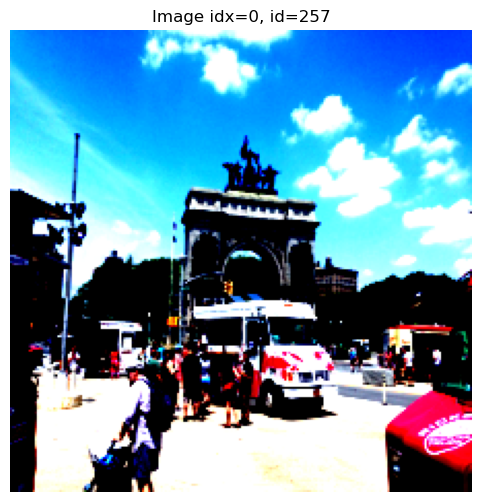

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


  Annotations:
    id= 1 (traffic light) bbox= [31.254999999999995, 92.04533333333335, 39.4905, 107.34266666666667]
    id= 1 (traffic light) bbox= [17.5945, 92.92733333333334, 26.375999999999998, 104.01533333333333]
    id= 1 (traffic light) bbox= [79.5795, 138.36666666666667, 83.5345, 143.682]
    id= 1 (traffic light) bbox= [9.652999999999999, 141.4466666666667, 11.644499999999997, 144.7646666666667]
    id= 1 (traffic light) bbox= [10.125499999999999, 129.08, 12.1625, 134.568]
    id= 8 (handbag) bbox= [107.359, 168.07466666666667, 111.7375, 174.50066666666666]
    id= 1 (traffic light) bbox= [31.4755, 83.05266666666667, 36.736, 89.88933333333334]
    id= 8 (handbag) bbox= [32.595499999999994, 160.64533333333333, 34.653499999999994, 166.46933333333334]
    id= 1 (traffic light) bbox= [105.693, 121.716, 108.1745, 128.33333333333334]
    id= 1 (traffic light) bbox= [103.46000000000001, 121.98666666666666, 105.6965, 127.67999999999999]
    id= 1 (traffic light) bbox= [19.3899999999999

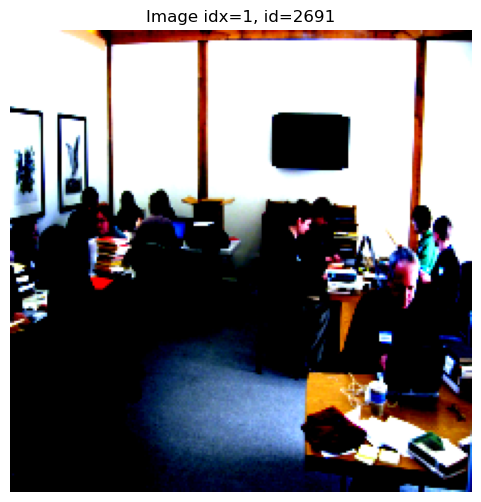

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


  Annotations:
    id= 6 (laptop) bbox= [177.27499999999998, 152.45533333333333, 211.59249999999997, 179.326]
    id= 6 (laptop) bbox= [154.4585, 105.87733333333334, 171.67499999999998, 121.61800000000001]
    id= 6 (laptop) bbox= [160.62199999999999, 98.90533333333333, 173.495, 115.11733333333333]
    id= 6 (laptop) bbox= [172.62349999999998, 98.97533333333334, 183.575, 118.48666666666666]
    id= 6 (laptop) bbox= [174.671, 104.37466666666667, 182.7735, 125.272]
    id= 6 (laptop) bbox= [0.0, 113.918, 19.354999999999997, 143.10333333333335]
    id= 6 (laptop) bbox= [32.739, 102.844, 38.8045, 118.47266666666667]
    id= 6 (laptop) bbox= [50.0675, 89.94066666666666, 55.912499999999994, 97.874]
    id= 6 (laptop) bbox= [77.161, 90.88333333333334, 85.8795, 104.35600000000001]
----------------------------------------


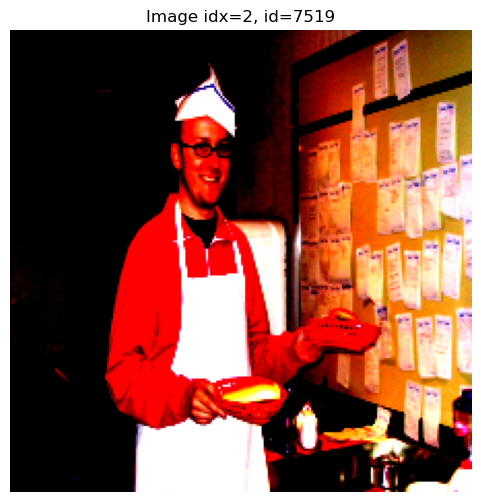

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].


  Annotations:
    id= 0 (hot dog) bbox= [101.227, 170.09066666666666, 131.999, 181.74333333333337]
    id= 4 (dining table) bbox= [15.4735, 179.41, 28.388499999999997, 197.39533333333335]
----------------------------------------


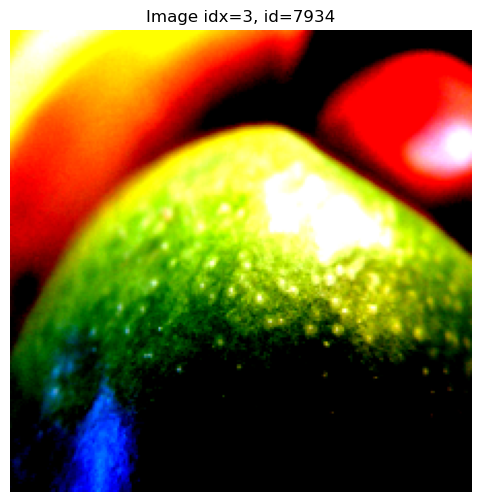

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.6051416].


  Annotations:
    id= 2 (apple) bbox= [0.39549999999999996, 41.636, 223.34199999999998, 221.36333333333334]
    id= 2 (apple) bbox= [141.51549999999997, 4.741333333333333, 224.0, 100.66933333333334]
----------------------------------------


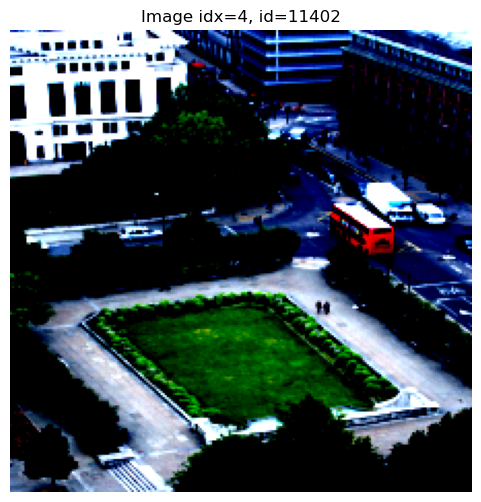

  Annotations:
    id= 7 (bus) bbox= [154.45508196721312, 83.202, 186.7016393442623, 109.7845]
    id= 1 (traffic light) bbox= [183.13967213114756, 111.3385, 186.03540983606558, 115.4895]
    id= 1 (traffic light) bbox= [135.1081967213115, 36.9005, 137.11737704918033, 39.942]
    id= 1 (traffic light) bbox= [126.94557377049182, 35.742, 128.30426229508197, 37.618]
    id= 1 (traffic light) bbox= [124.68983606557377, 39.199999999999996, 127.24983606557377, 42.826]
    id= 1 (traffic light) bbox= [163.27868852459017, 54.334, 165.80196721311475, 55.6605]
    id= 1 (traffic light) bbox= [118.11147540983607, 90.71999999999998, 119.99475409836067, 94.49299999999998]
----------------------------------------


In [2]:
from utils import get_loaders
import os, pathlib
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

# 讀 loader
loaders    = get_loaders("det",
                         batch_size=1,
                         num_workers=0,
                         data_root=pathlib.Path(os.path.dirname(os.getcwd()))/"data")
val_loader = loaders["train"]
dataset    = val_loader.dataset

# COCO id → name
categories     = dataset.coco.cats
cat_id_to_name = {cid: info["name"] for cid, info in categories.items()}

for idx in range(5):
    img, anns = dataset[idx]
    img_id    = dataset.ids[idx]

    # 1) 顯示影像
    plt.figure(figsize=(6,6))
    if isinstance(img, torch.Tensor):
        # Tensor → H×W×C, unnormalize if needed
        arr = img.permute(1,2,0).cpu().numpy()
        # 如果你有 normalize，這裡要 *std + mean
        plt.imshow(arr)
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image idx={idx}, id={img_id}")
    plt.show()

    # 2) 列出 annotation
    print("  Annotations:")
    for ann in anns:
        cid      = ann["category_id"]
        cname    = cat_id_to_name.get(cid, "Unknown")
        bbox     = ann.get("bbox", ann.get("boxes", None))
        print(f"    id={cid:2d} ({cname})", "bbox=", bbox)
    print("-"*40)


In [2]:
from utils import get_loaders
import os, pathlib
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

# 讀 loader
loaders    = get_loaders("det",
                         batch_size=1,
                         num_workers=0,
                         data_root=pathlib.Path(os.path.dirname(os.getcwd()))/"data",device=torch.device("cuda"))
val_loader = loaders["train"]
dataset    = val_loader.dataset


all_labels = []
for ann in dataset.coco.anns.values():
    all_labels.append(ann['category_id'] - 1)
all_labels = set(all_labels)

print("unique labels:", sorted(all_labels))
print("num_classes:", len(all_labels))
print("max label index:", max(all_labels))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
unique labels: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
num_classes: 10
max label index: 8


## 建構dataloader

因為COCO dataset的一張圖片對應一個list of annotations，在建構batch的時候會出錯。

所以要將 batch: (image, anns: List),(image, anns: List),...,(image, anns: List) -> return (list(image,image,...,image),list(anns,anns,...,anns))

In [150]:
def detection_collate_fn(batch):
    return tuple(zip(*batch))  # 回傳 (images, targets) 分開的 tuple

# jupyter notebook 的 num_workers 會有問題，這裡設為 0
miniCOCO_train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0, collate_fn=detection_collate_fn)
miniCOCO_val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=0, collate_fn=detection_collate_fn)

In [154]:
# Get a batch of images and annotations from the train loader
images, targets = next(iter(miniCOCO_val_loader))

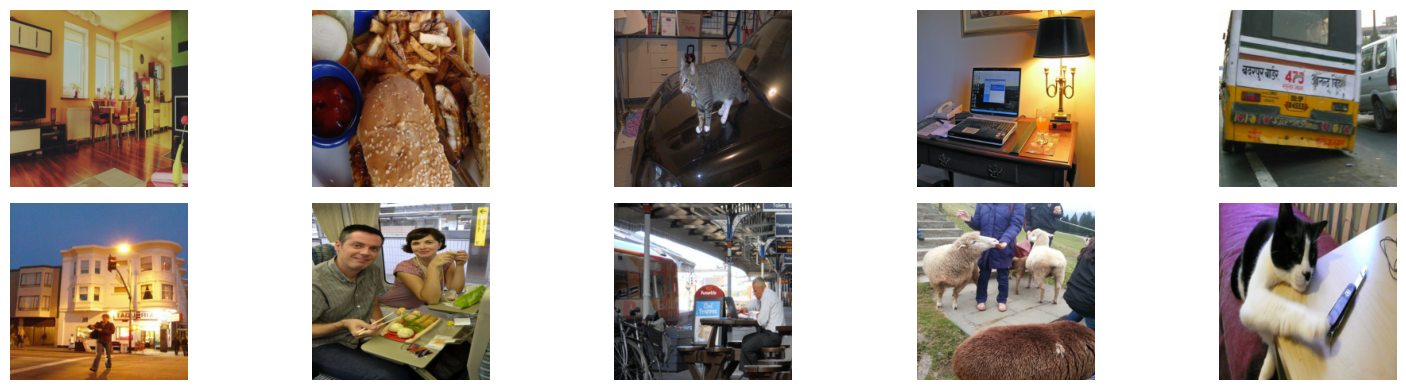

In [158]:
# Display the first 10 images in the batch
fig, axs = plt.subplots(2, 5, figsize=(16, 4))
axs = axs.flatten() # subplot設定2d就要記得攤平index
for i in range(10):
    # img = np.array(images[i])
    img = images[i].permute(1, 2, 0).numpy()
    img = img*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    axs[i].imshow(img)
    axs[i].axis('off')
plt.tight_layout()
plt.show()